### Projet NLP - Analyse de sentiment
*par Luan DECHERY et Enrique NASSEH FREITAS*

lien du tutoriel : https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners

Dans le cadre du cours de NLP du Master MIASHS, nous devons appliquer les connaissances acquises en réalisant un projet d'analyse de données textuelles. L'objectif de ce projet est de résoudre un problème de classification par le biais d'une analyse de sentiment de tweets en français.

Pour atteindre cet objectif, nous allons suivre une méthodologie structurée en plusieurs étapes :


1.   **Préparation des données :** Cette étape comprendra la collecte de tweets
pertinents, le nettoyage des données, et leur mise en forme pour garantir leur
qualité et pertinence pour l'analyse.
   

2.   **Analyse exploratoire :** Nous explorerons les données pour en extraire des tendances et des caractéristiques clés, et visualiser les distributions des sentiments.

3.   **Création du modèle :** Nous développerons et entraînerons un modèle de machine learning capable de classifier les sentiments (positif, négatif, neutre) en utilisant des approches supervisées et des techniques de NLP.

4.   **Conclusion :** Enfin, nous évaluerons la performance du modèle et discuterons des résultats, des défis rencontrés et des perspectives d'amélioration pour les futurs travaux.


# Importation des paquets

In [ ]:
import pandas as pd
#!pip install demoji
#import demoji
import re
import spacy
import nltk
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords_fr_nltk = stopwords.words('french')



import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


#modèles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/csv/french_tweets.csv"

df = pd.read_csv(path, encoding='utf-8')
df.head()

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."


In [ ]:
len(df)

1526724

In [ ]:
def clean_text(text):
    # lowercase
    text = text.lower()
    # remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text= re.sub(r'[@/#]', '', text)
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    text = re.sub(r'_+', '', text)
    # Supprime les valeurs n'étant pas dans le bon alphabet
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)
    #url
    text = re.sub(r'http\S+', 'URL', text)
    # Supprime les valeurs vides
    text = re.sub(r'\s+', ' ', text).strip()
    #Supprime les emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    #Replace 3 or more consecutive letters by 2 letter.
    text = re.sub(r"(.)\1\1+", r"\1\1", text)
    return text

In [ ]:
df['text']=df['text'].apply(clean_text)

In [ ]:
print(len(df))
df.head()

1526724


,label,text
0,0,aww c est un bummer tu devrais avoir david car...
1,0,est contrarié qu il ne puisse pas mettre à jou...
2,0,j ai plongé plusieurs fois pour la balle a réu...
3,0,tout mon corps a des démangeaisons et comme si...
4,0,non il ne se comporte pas du tout je suis en c...


In [ ]:
!python -m spacy download fr_core_news_sm
nlp = spacy.load("fr_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 89.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Fonction pour lemmatiser la colonne des commentaires
def lemmatize_text(text):
  doc = nlp(text)
  lemmatized_text = ' '.join([token.lemma_ for token in doc])
  return lemmatized_text

#Lemmatisation de la colonne "text"
df['text_lemm'] = df['text'].apply(lemmatize_text)

In [ ]:
df.to_csv("df_lemmatized.csv", index=False)

In [ ]:
df.iloc[1]['text']

'est contrarié qu il ne puisse pas mettre à jour son facebook en le télémaignant et peut être pleurer en conséquence l école aujourd hui aussi blabla'

In [ ]:
df_lemmatized = pd.read_csv("df_lemmatized.csv")
df_lemmatized.head()

,label,text,text_lemm
0,0,aww c est un bummer tu devrais avoir david car...,aww c être un bummer tu devoir avoir david car...
1,0,est contrarié qu il ne puisse pas mettre à jou...,être contrarier qu il ne pouvoir pas mettre à ...
2,0,j ai plongé plusieurs fois pour la balle a réu...,j avoir plonger plusieurs fois pour le balle a...
3,0,tout mon corps a des démangeaisons et comme si...,tout mon corps avoir un démangeaison et comme ...
4,0,non il ne se comporte pas du tout je suis en c...,non il ne se comporte pas de tout je être en c...


In [ ]:
len(df_lemmatized)

579201

In [ ]:
print(df_lemmatized.dtypes)

label         int64
text         object
text_lemm    object
dtype: object


In [ ]:
# Convert the 'text' and 'text_lemm' columns to string type
df_lemmatized['text'] = df_lemmatized['text'].astype(str)
df_lemmatized['text_lemm'] = df_lemmatized['text_lemm'].astype(str)

In [ ]:
#fonction pour enlever les mots d'une liste

def remove_stopwords(text, stwords):
  tokens = text.split()
  filtered_tokens = [token for token in tokens if token not in stwords]
  return ' '.join(filtered_tokens)

In [ ]:
print(len(stopwords_fr_nltk), ' : nb de stopwords dans nltk.')

157  : nb de stopwords dans nltk.


In [ ]:
df_lemmatized['text_lemm_nltk'] = df_lemmatized['text_lemm'].apply(lambda x : remove_stopwords(x, stopwords_fr_nltk))

###Exploration des données





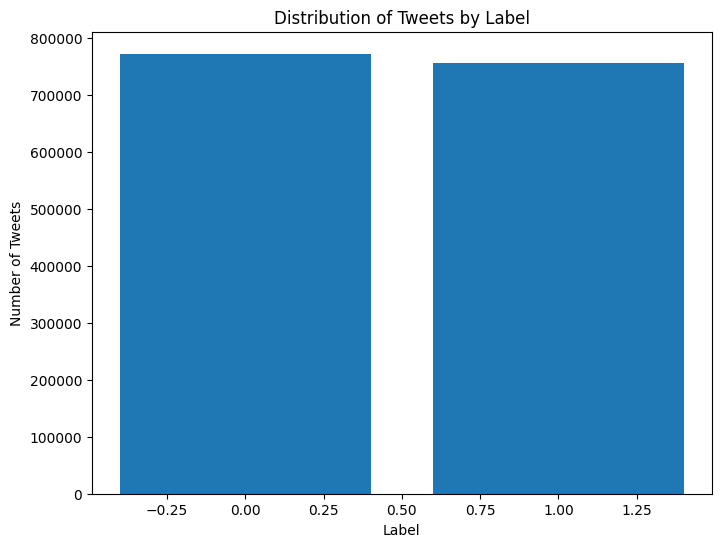

         text
label        
0      771604
1      755120


In [ ]:
label_counts = df_lemmatized['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets by Label')
plt.show()

print(df.groupby('label').count())

On voit que le jeu de données est équilibré.

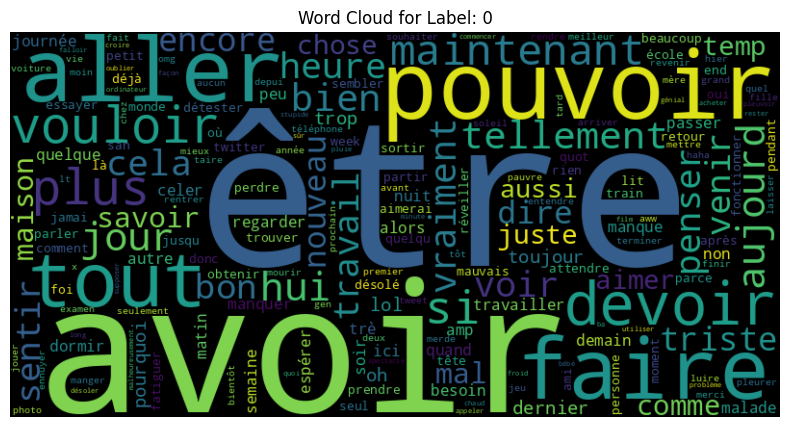

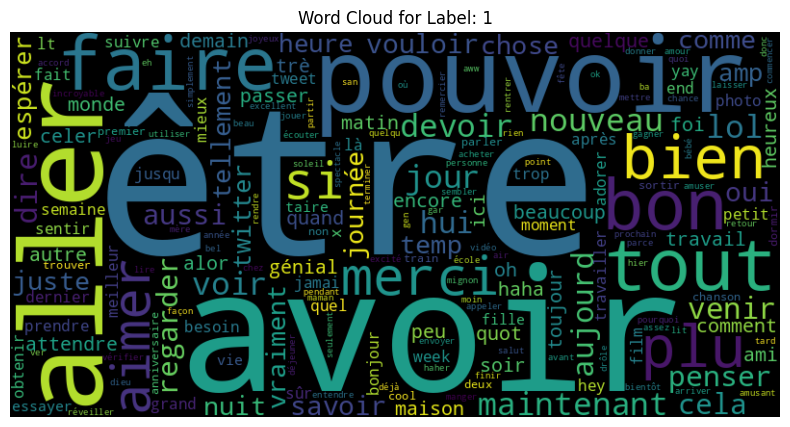

In [ ]:
#WordCloud
grouped_df = df_lemmatized.groupby('label')

for label, group in grouped_df:
  text = ' '.join(group['text_lemm_nltk'].astype(str))
  wordcloud = WordCloud(width=800, height=400, background_color='black', collocations = False).generate(text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Label: {label}')
  plt.show()

On voit qu'on a beaucoup de mots pareil dans les 2 graphiques, nous allons essayer d'enlever ces mots.

on va réessayer d'enlever les stopwords maintenant avec le package spacy (nltk avant).
Le package spacy ayant plus de stopwords que le nltk

In [ ]:
if 'text_lemm_nltk' in df_lemmatized.columns:
  df_lemmatized = df_lemmatized.drop('text_lemm_nltk', axis=1)

In [ ]:
df_lemmatized.head()

,label,text,text_lemm
0,0,aww c est un bummer tu devrais avoir david car...,aww c être un bummer tu devoir avoir david car...
1,0,est contrarié qu il ne puisse pas mettre à jou...,être contrarier qu il ne pouvoir pas mettre à ...
2,0,j ai plongé plusieurs fois pour la balle a réu...,j avoir plonger plusieurs fois pour le balle a...
3,0,tout mon corps a des démangeaisons et comme si...,tout mon corps avoir un démangeaison et comme ...
4,0,non il ne se comporte pas du tout je suis en c...,non il ne se comporte pas de tout je être en c...


In [ ]:
from spacy.lang.fr.stop_words import STOP_WORDS as stopwords_fr_spacy

In [ ]:
print(len(stopwords_fr_spacy), ' : nb de stopwords dans spacy.')

507  : nb de stopwords dans spacy.


In [ ]:
df_lemmatized['text'] = df_lemmatized['text'].astype(str)

In [ ]:
df_lemmatized['text'] = df_lemmatized['text'].apply(lambda x : remove_stopwords(x, stopwords_fr_spacy))

In [ ]:
df_lemmatized.dtypes

,0
label,int64
text,object


In [ ]:
df_lemmatized.to_csv("df_lemmatized_stopwords.csv", index=False)

In [ ]:
df_lemmatized.head()

,label,text,text_lemm,text_lemm_spacy
0,0,aww c est un bummer tu devrais avoir david car...,aww c être un bummer tu devoir avoir david car...,aww c bummer devoir david carr jour faire ré
1,0,est contrarié qu il ne puisse pas mettre à jou...,être contrarier qu il ne pouvoir pas mettre à ...,contrarier qu pouvoir mettre jour facebook tél...
2,0,j ai plongé plusieurs fois pour la balle a réu...,j avoir plonger plusieurs fois pour le balle a...,j plonger fois balle réussir économiser sort l...
3,0,tout mon corps a des démangeaisons et comme si...,tout mon corps avoir un démangeaison et comme ...,corps démangeaison c feu
4,0,non il ne se comporte pas du tout je suis en c...,non il ne se comporte pas de tout je être en c...,non comporte colère ici pouvoir voir partout


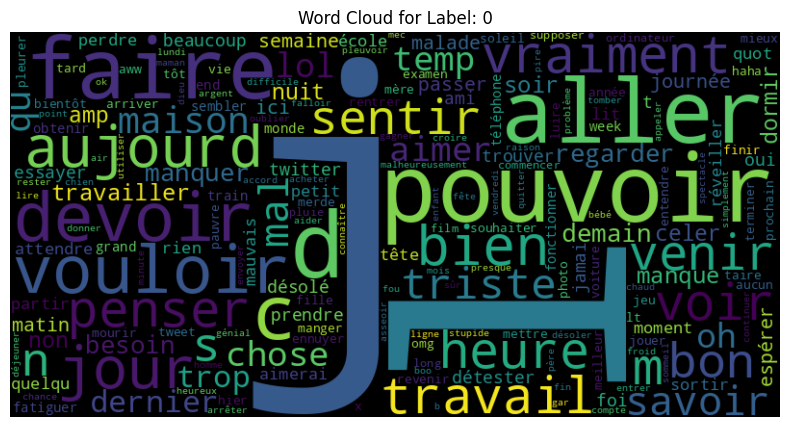

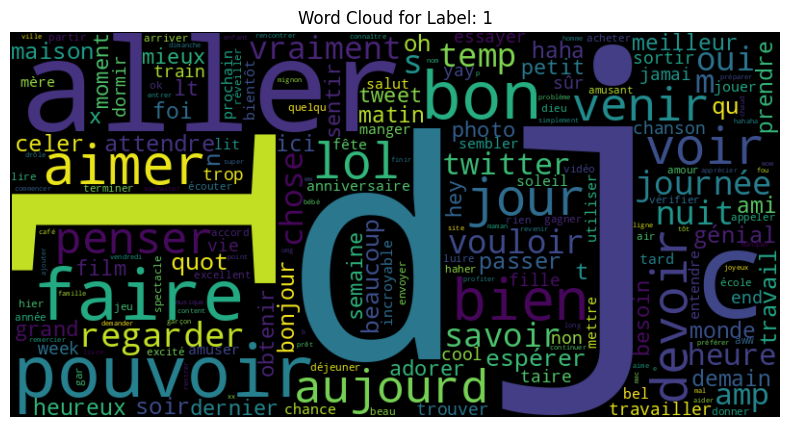

In [ ]:
#WordCloud
grouped_df = df_lemmatized.groupby('label')

for label, group in grouped_df:
  text = ' '.join(group['text_lemm_spacy'].astype(str))
  wordcloud = WordCloud(width=800, height=400, background_color='black', collocations = False).generate(text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Label: {label}')
  plt.show()

In [ ]:
#enlever les mots avec 1 lettre
df_lemmatized['text'] = df_lemmatized['text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

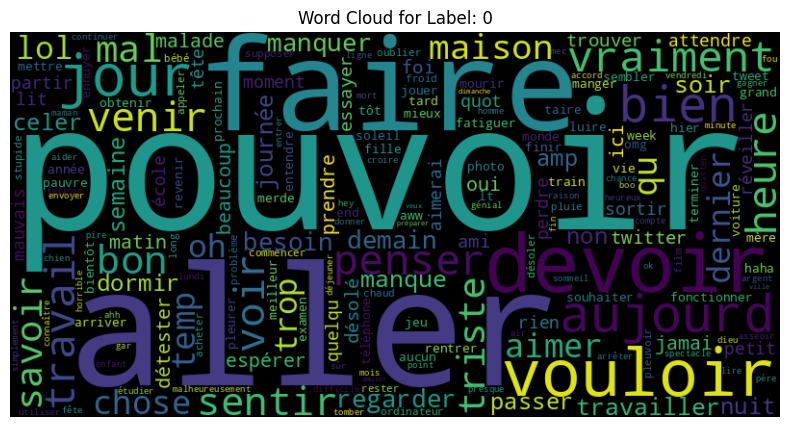

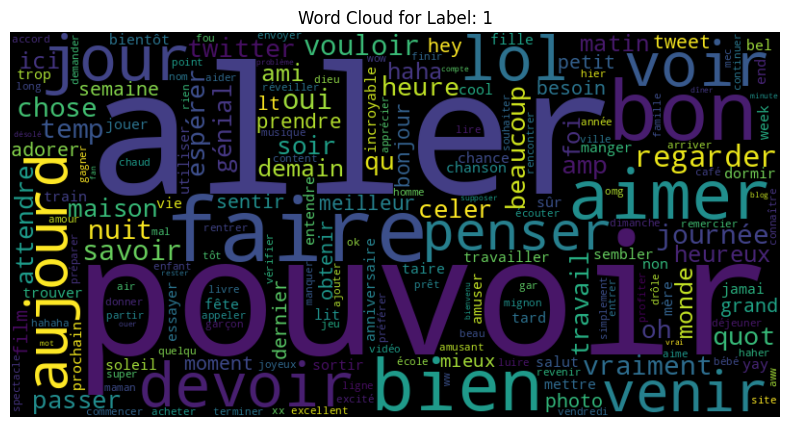

In [ ]:
#WordCloud
grouped_df = df_lemmatized.groupby('label')

for label, group in grouped_df:
  text = ' '.join(group['text_lemm_spacy'].astype(str))
  wordcloud = WordCloud(width=800, height=400, background_color='black', collocations = False).generate(text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Label: {label}')
  plt.show()

In [ ]:
words_to_remove = ['faire', 'aller', 'pouvoir']
df_lemmatized['text_lemm_spacy'] = df_lemmatized['text_lemm_spacy'].apply(lambda x: remove_stopwords(x, words_to_remove))

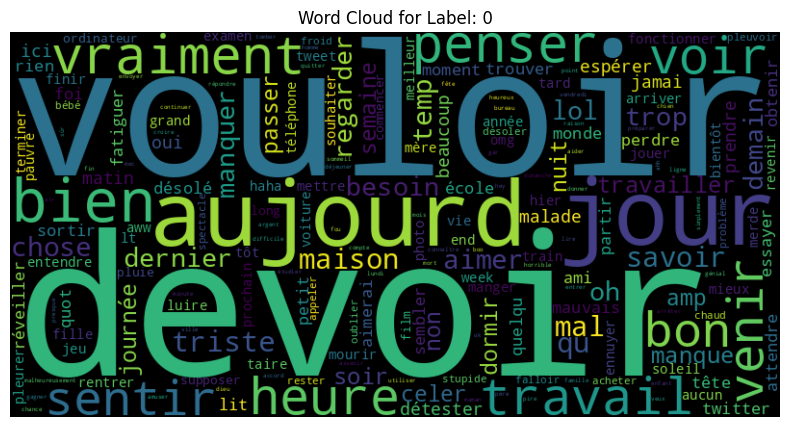

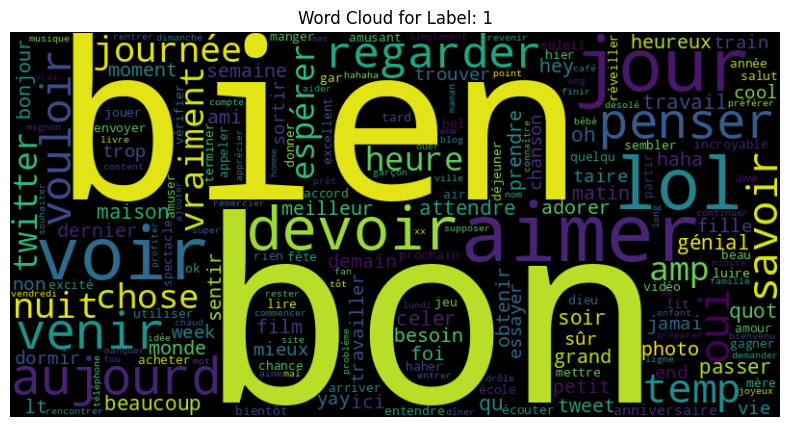

In [ ]:
#WordCloud
grouped_df = df_lemmatized.groupby('label')

for label, group in grouped_df:
  text = ' '.join(group['text_lemm_spacy'].astype(str))
  wordcloud = WordCloud(width=800, height=400, background_color='black', collocations = False).generate(text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Label: {label}')
  plt.show()

In [ ]:
df_lemmatized.to_csv("df_lemmatized_stopwords.csv", index=False)

#Embedding

In [ ]:
df_lemmatized = pd.read_csv("output.txt", sep = '\t')
df_lemmatized.head()

,label,text,text_lemm
0,0,aww c est un bummer tu devrais avoir david car...,aww c être un bummer tu devoir avoir david car...
1,0,est contrarié qu il ne puisse pas mettre à jou...,être contrarier qu il ne pouvoir pas mettre à ...
2,0,j ai plongé plusieurs fois pour la balle a réu...,j avoir plonger plusieurs fois pour le balle a...
3,0,tout mon corps a des démangeaisons et comme si...,tout mon corps avoir un démangeaison et comme ...
4,0,non il ne se comporte pas du tout je suis en c...,non il ne se comporte pas de tout je être en c...


In [ ]:
df_lemmatized['text'] = df_lemmatized['text_lemm']

In [ ]:
df_lemmatized.drop('text_lemm', axis=1, inplace=True)
df_lemmatized.head()

,label,text
0,0,aww c être un bummer tu devoir avoir david car...
1,0,être contrarier qu il ne pouvoir pas mettre à ...
2,0,j avoir plonger plusieurs fois pour le balle a...
3,0,tout mon corps avoir un démangeaison et comme ...
4,0,non il ne se comporte pas de tout je être en c...


In [ ]:
df_lemmatized['text'] = df_lemmatized['text'].astype(str)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_lemmatized['text'].values.astype('U'),
                                                    df_lemmatized['label'],
                                                    test_size = 0.33,
                                                    random_state = 42)
print(f'Data Split done.')

Data Split done.


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

NameError: name 'vectoriser' is not defined

##Evaluation du modèle

In [ ]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test_embeddings)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.74      0.75      0.74    254330
           1       0.74      0.73      0.73    249489

    accuracy                           0.74    503819
   macro avg       0.74      0.74      0.74    503819
weighted avg       0.74      0.74      0.74    503819



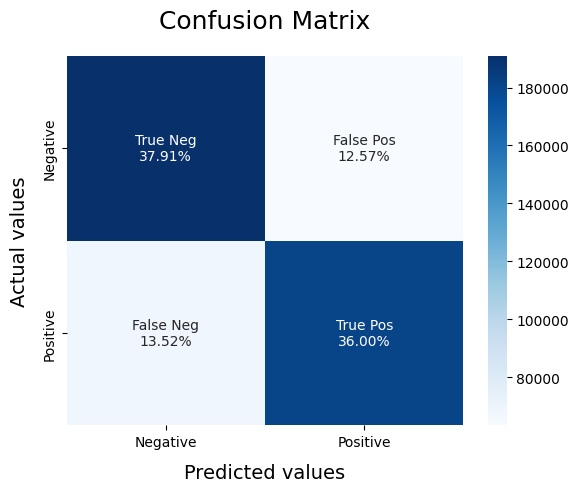

In [ ]:
LRmodel = LogisticRegression(penalty='l2', C = 2, max_iter = 500,
                             n_jobs=-1, random_state=42,
                             solver = 'lbfgs')
LRmodel.fit(X_train_embeddings, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    254330
           1       0.75      0.80      0.78    249489

    accuracy                           0.77    503819
   macro avg       0.77      0.77      0.77    503819
weighted avg       0.77      0.77      0.77    503819



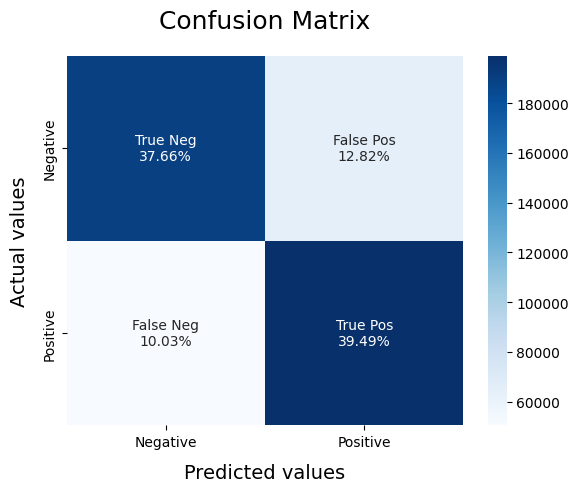

In [ ]:
BNBmodel = BernoulliNB(alpha = 1)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

In [ ]:
SVCmodel = SVC(kernel = 'rbf', degree = 3, gamma = 'scale', probability=True)
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

Test de plusieurs paramètres

In [ ]:
results = []

for alpha in [0.5, 1.0, 1.5]:
    model = BernoulliNB(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append(["BernoulliNB", alpha, "-", accuracy])

for C in [0.1, 1.0, 10.0]:
    for penalty in ["l1","l2"]:
        model = LogisticRegression(C=C, penalty=penalty, solver='liblinear', max_iter=200, multi_class='auto')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append(["LogisticRegression", "-", f"C={C}, penalty={penalty}, solver= liblinear", accuracy])

for C in [0.1, 1.0, 10.0]:
    for penalty in ["l2"]:
        model = LogisticRegression(C=C, penalty=penalty, solver='sag', max_iter=200, multi_class='auto')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append(["LogisticRegression", "-", f"C={C}, penalty={penalty}, solver= sag", accuracy])

df_results = pd.DataFrame(results, columns=["Model", "alpha", "Parameters", "Accuracy"])
print(df_results)


Modèle avec les paramètres optimales

In [ ]:
model = LogisticRegression(C=1, penalty="l2", solver='sag', max_iter=200, multi_class='auto')
logreg = model.fit(X_train, y_train)
model_Evaluate(logreg)